# Creating custom Adapters
Adapters play a crucial role in data preprocessing. Namely, they carry the logic for transforming data from `StandardFrameData` to `TransformedFrameData` which in its order is saved to cache and used for training.

<div style="display:flex;align-items:center;gap:10px;flex-wrap:wrap;">
  <span style="border:1px solid #999;padding:6px 10px;border-radius:4px;">Raw Frame</span>

  <span style="display:inline-flex;flex-direction:column;align-items:center;line-height:1;">
    <small>dataset-specific logic</small>
    <span style="letter-spacing:6px;white-space:nowrap;">----&gt;</span>
  </span>

  <span style="border:1px solid #999;padding:6px 10px;border-radius:4px;">
    StandardFrameData
  </span>

  <span style="display:inline-flex;flex-direction:column;align-items:center;line-height:1;">
    <span style="font-size:12px;">Adapter</span>
    <span style="letter-spacing:6px;white-space:nowrap;">----&gt;</span>
  </span>

  <span style="border:1px solid #999;padding:6px 10px;border-radius:4px;">
    TransformedFrameData
  </span>
</div>

Implementing custom adapters can greatly expand the functionality of StandardE2E hence here we cover how to create a new one. We will consider a simple example - creating an adapter for camera images that would output only the view from the front camera. The transformation logic is held by `_transform` method that accepts `StandardFrameData` as input

In [ ]:
input_path = "path/to/waymo_open_dataset_end_to_end_camera_v_1_0_0"


In [2]:
from typing import Any
import albumentations as A
from standard_e2e.data_structures.frame_data import StandardFrameData
from standard_e2e.enums import CameraDirection, Modality
from standard_e2e.caching.adapters.abstract_adapter import AbstractAdapter

class FrontCameraAdapter(AbstractAdapter):
    def __init__(self, max_size: int = 640):
        super().__init__()
        self._image_transform = A.LongestMaxSize(max_size=max_size, p=1.0)

    @property
    def name(self) -> str:
        return "front_camera_adapter"

    def _transform(self, standard_frame_data: StandardFrameData) -> dict[Modality, Any]:
        original_front_image = standard_frame_data.cameras[CameraDirection.FRONT].image
        adapted_image = self._image_transform(image=original_front_image)["image"]
        return {Modality.CAMERAS: adapted_image}

2025-12-24 05:37:05.268632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%env STANDARD_E2E_DEBUG=true

import os
import tempfile
from glob import glob
from standard_e2e.caching.src_datasets.waymo_e2e import (
    WaymoE2EDatasetConverter,
    WaymoE2EDatasetProcessor,
)
from standard_e2e.data_structures.frame_data import TransformedFrameData

with tempfile.TemporaryDirectory() as output_path:
    processor = WaymoE2EDatasetProcessor(
        common_output_path=output_path,
        split="val",
        adapters=[FrontCameraAdapter(max_size=128)],
    )

    converter = WaymoE2EDatasetConverter(
        source_processor=processor,
        input_path=input_path,
        split="val",
        num_workers=32,
        do_parallel_processing=True,
    )

    converter.convert()

    processed_files = glob(os.path.join(output_path, "waymo_e2e", "val", "*.npz"))
    frame_data = TransformedFrameData.from_npz(processed_files[-1])


env: STANDARD_E2E_DEBUG=true


Processing                             waymo_e2e dataset: 0it [00:00, ?it/s]2025-12-24 05:37:07.263828: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144
Processing                             waymo_e2e dataset: 1114it [00:04, 283.08it/s]2025-12-24 05:37:11.657640: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Processing                             waymo_e2e dataset: 1150it [00:04, 258.23it/s]


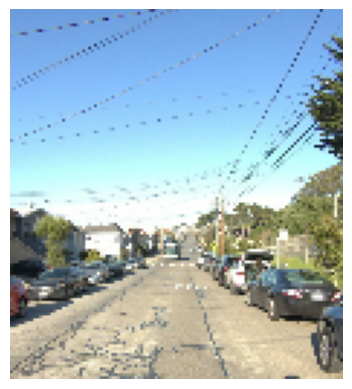

In [4]:
from matplotlib import pyplot as plt

plt.imshow(frame_data.get_modality_data(Modality.CAMERAS))
plt.axis("off")
plt.show()